In [27]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-hf", torch_dtype="auto", device_map="auto")
model.eval()
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [28]:
def shannon_entropy(px, dim=None, keepdim=False):
    """
    Calculate Shannon entropy: -sum(p(x) * log2(p(x)))
    
    Args:
        px: probability distribution tensor (assumes sum to 1 along specified dim)
        dim: dimension along which to compute entropy (None means all dimensions)
        keepdim: whether to keep the reduced dimension
    
    Returns:
        Shannon entropy tensor
    """
    # Convert to torch tensor if it's a numpy array
    if isinstance(px, np.ndarray):
        px = torch.from_numpy(px)
    
    # Avoid log(0) by adding small epsilon where px is 0
    eps = 1e-10
    eps_tensor = torch.tensor(eps, device=px.device, dtype=px.dtype)
    px_safe = torch.where(px > 0, px, eps_tensor)
    
    # Calculate Shannon entropy: -sum(p(x) * log2(p(x)))
    log_px = torch.log2(px_safe)
    entropy_terms = px * log_px
    
    # Only include terms where px > 0 (set others to 0)
    zero_tensor = torch.tensor(0.0, device=px.device, dtype=px.dtype)
    entropy_terms = torch.where(px > 0, entropy_terms, zero_tensor)
    
    # Sum along specified dimension
    entropy = -torch.sum(entropy_terms, dim=dim, keepdim=keepdim)
    
    return entropy

In [29]:
model_inputs = tokenizer(["If you want, I can"], return_tensors="pt").to("cuda")
generated_ids = model(**model_inputs, output_attentions=True, output_hidden_states=True)

In [38]:
batch_index = 0
attention_entropy = None
proxy_attn_entropy = None
proxy_dot_prod = None
hidden_state_cos = None
hidden_state_dis = None

# # Calculate entropy for each attention head in the first layer
for layer_idx in range(len(generated_ids.attentions)):
    # (heads, seq_len, seq_len)
    attention_matrix = (
        generated_ids.attentions[layer_idx][batch_index].cpu().detach().numpy()
    )

    hidden_state_cos_step = F.cosine_similarity(
        generated_ids.hidden_states[layer_idx + 1],
        generated_ids.hidden_states[layer_idx],
        dim=-1,
    )
    hidden_state_dis_step = torch.linalg.norm(
        generated_ids.hidden_states[layer_idx + 1]
        - generated_ids.hidden_states[layer_idx],
        dim=-1,
    )

    # dim -1, shape (heads, seq_len)
    entropy_per_row = shannon_entropy(attention_matrix, dim=-1).unsqueeze(0)

    # dim -1, shape (seq_len, seq_len)
    dot_prod = F.softmax(6e-8+
        torch.einsum(
            "ijk,igh->ijg",
            generated_ids.hidden_states[layer_idx + 1],
            generated_ids.hidden_states[layer_idx + 1],
        )
        / generated_ids.hidden_states[layer_idx + 1].shape[-1],
        dim=-1,
    )
    # dim -1, shape (1, seq_len)
    attn_proxy = shannon_entropy(dot_prod, dim=-1)

    if attention_entropy is None:
        attention_entropy = entropy_per_row
        hidden_state_cos = hidden_state_cos_step
        hidden_state_dis = hidden_state_dis_step
        proxy_attn_entropy = attn_proxy
        proxy_dot_prod = dot_prod

    else:
        attention_entropy = torch.cat((attention_entropy, entropy_per_row))
        hidden_state_cos = torch.cat((hidden_state_cos, hidden_state_cos_step))
        hidden_state_dis = torch.cat((hidden_state_dis, hidden_state_dis_step))
        proxy_attn_entropy = torch.cat((proxy_attn_entropy, attn_proxy))
        proxy_dot_prod = torch.cat((proxy_dot_prod, dot_prod))


# Get lm_head and compute logits for each layer's hidden states
lm_head = model.lm_head
predicted_tokens = []
norm = model.model.norm

logit_entropy_per_layer = []
token_id = 1

for layer_idx in range(len(generated_ids.hidden_states)):
    # Project hidden state to vocab space
    hidden_state = generated_ids.hidden_states[layer_idx][:, token_id, :].unsqueeze(
        1
    )  # Shape: [batch, 1, hidden_dim]
    logits = lm_head(
        norm(hidden_state) if layer_idx < 31 else hidden_state
    )  # Shape: [batch, 1, vocab_size]
    # Get predicted token

    predicted_token_id = torch.argmax(logits, dim=-1).squeeze().item()
    predicted_token = tokenizer.decode([predicted_token_id])
    predicted_tokens.append(predicted_token)

    probs = torch.softmax(logits, dim=-1).squeeze((0, 1))
    entropy = -(probs * torch.log2(probs + 6e-8)).sum()
    logit_entropy_per_layer.append(entropy.item())

/tmp/ipykernel_323119/3513462573.py:79: UserWarning: Glyph 28716 (\N{CJK UNIFIED IDEOGRAPH-702C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/nfs-share/pa511/code_bases/dyna_project/dyna/.venv/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 28716 (\N{CJK UNIFIED IDEOGRAPH-702C}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/nfs-share/pa511/code_bases/dyna_project/dyna/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28716 (\N{CJK UNIFIED IDEOGRAPH-702C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


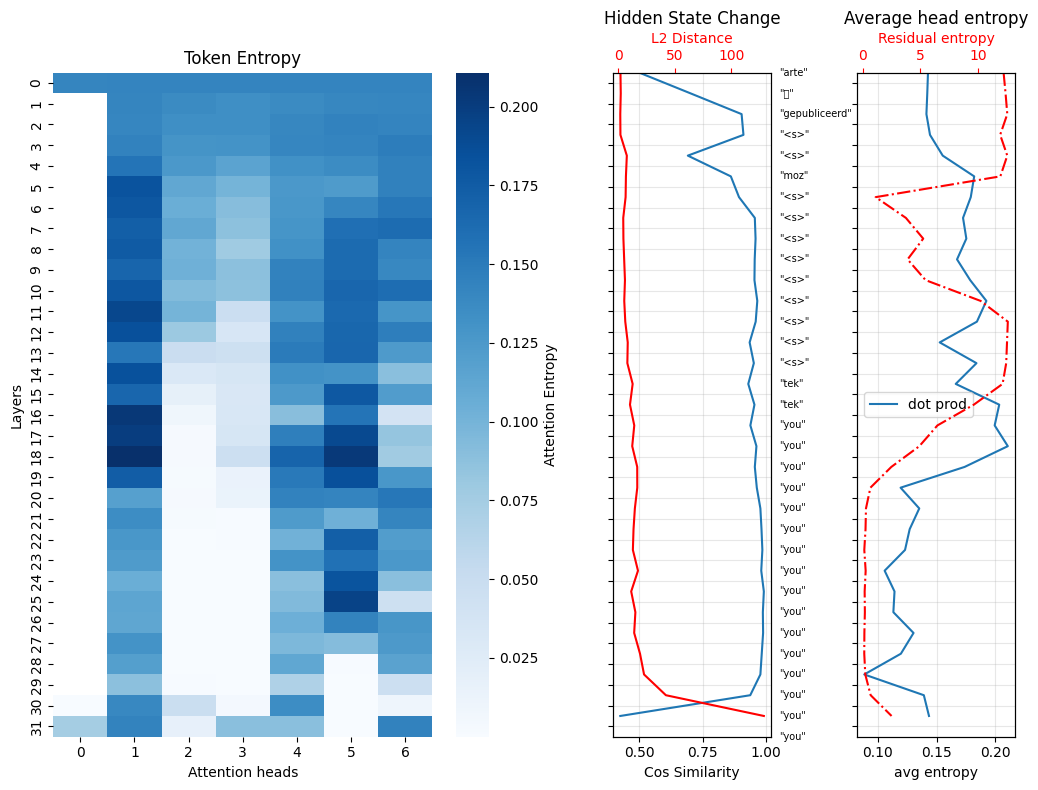

In [40]:
hidden_state_change_token_cos = hidden_state_cos[:, token_id].detach().cpu().numpy()
hidden_state_change_token_dis = hidden_state_dis[:, token_id].detach().cpu().numpy()
attention_entropy_token = attention_entropy[..., token_id].detach().cpu().numpy()
proxy_dot_prod_token = proxy_dot_prod[..., token_id].detach().cpu().numpy()
proxy_attn_entropy_token = proxy_attn_entropy[..., token_id].detach().cpu().numpy()


# Create subplots with shared y-axis and width ratio 3:2 (less space for text)
fig, (ax1, ax2, ax3) = plt.subplots(
    1, 3, figsize=(12, 8), gridspec_kw={"width_ratios": [3, 1, 1]}, sharey=True
)

# Left plot: Attention entropy heatmap
sns.heatmap(
    proxy_dot_prod_token,
    annot=False,  # Set to True if you want to see values
    cmap="Blues",
    cbar_kws={"label": "Attention Entropy"},
    ax=ax1,
)

ax1.set_title("Token Entropy")
ax1.set_xlabel("Attention heads")
ax1.set_ylabel("Layers")

# Right plot: Hidden state change
ax2.plot(hidden_state_change_token_cos, range(len(hidden_state_change_token_cos)))

# Add secondary x-axis for hidden_state_change_token_dis
ax2b = ax2.twiny()
ax2b.plot(
    hidden_state_change_token_dis,
    range(len(hidden_state_change_token_dis)),
    color="red",
)
ax2b.set_xlabel("L2 Distance", color="red")
ax2b.tick_params(axis="x", colors="red")

# ax3.plot(
#     attention_entropy_token.mean(dim=-1), range(len(hidden_state_change_token_cos))
# )
means = proxy_dot_prod_token[:,token_id]
ax3.plot(
    means,
    range(32),
    label="dot prod",
)
ax3b = ax3.twiny()
ax3b.set_xlabel("Residual entropy", color="red")
ax3b.plot(
    logit_entropy_per_layer[1:],
    range(len(hidden_state_change_token_cos)),
    '-.',
    color="red",
    label="logit entropy",
)
ax3b.tick_params(axis="x", colors="red")
ax3.grid(True, alpha=0.3)
ax3.set_xlabel("avg entropy")
ax3.set_title("Average head entropy")
ax3.legend()


ax2.set_title("Hidden State Change")
ax2.set_xlabel("Cos Similarity")
ax2.grid(True, alpha=0.3)
# Add predicted tokens as text with tighter spacing
xlim = ax2.get_xlim()
for i, token1 in enumerate(predicted_tokens):
    ax2.text(
        xlim[1] + (xlim[1] - xlim[0]) * 0.05,
        i,
        f'"{token1}"',
        verticalalignment="center",
        fontsize=7,
    )

# Adjust layout to prevent text cutoff
plt.tight_layout()
plt.subplots_adjust(right=0.85)
# plt.show()

torch.Size([32, 7])


/tmp/ipykernel_323119/1456434059.py:31: UserWarning: Glyph 28716 (\N{CJK UNIFIED IDEOGRAPH-702C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_323119/1456434059.py:31: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_323119/1456434059.py:31: UserWarning: Glyph 23601 (\N{CJK UNIFIED IDEOGRAPH-5C31}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/nfs-share/pa511/code_bases/dyna_project/dyna/.venv/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 28716 (\N{CJK UNIFIED IDEOGRAPH-702C}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/nfs-share/pa511/code_bases/dyna_project/dyna/.venv/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/nfs-share/pa511/code_bases/dyna_project/dyna/.venv/lib/python3.12/site-packages/IPython/core/events.py:8

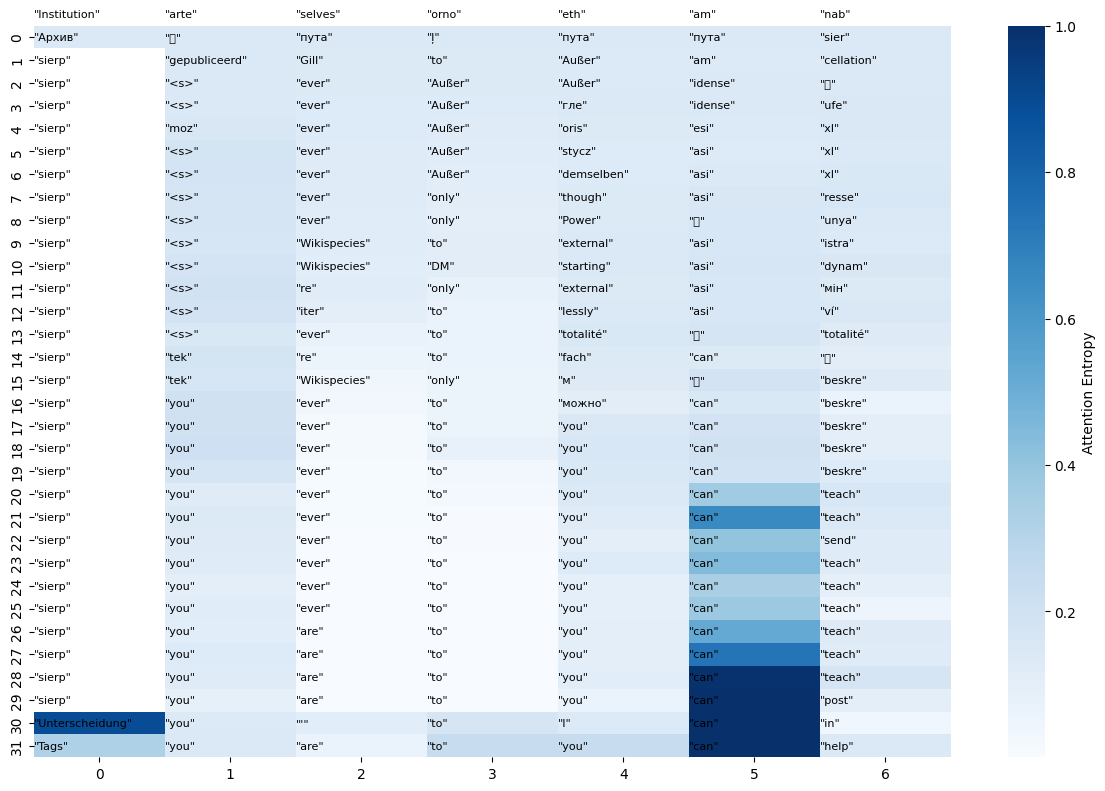

In [49]:
idx = torch.arange(proxy_dot_prod.shape[-1])
reses = proxy_dot_prod[:, idx, idx]
print(reses.shape)
reses = reses.detach().cpu().numpy()
predicted_tokens = []
for layer_idx in range(len(generated_ids.hidden_states)):
    # Project hidden state to vocab space
    hidden_state = generated_ids.hidden_states[layer_idx]  # Shape: [batch, 1, hidden_dim]
    logits = lm_head(norm(hidden_state) if layer_idx<31 else hidden_state)  # Shape: [batch, 1, vocab_size]
    
    # Get predicted token
    predicted_token_ids = torch.argmax(logits, dim=-1).tolist()[0]
    pts = [tokenizer.decode(i) for i in predicted_token_ids]
    predicted_tokens.append(pts)



fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))

sns.heatmap(reses, 
            annot=False,  # Set to True if you want to see values
            cmap='Blues',
            cbar_kws={'label': 'Attention Entropy'},
            ax=ax1)

# Print predicted token at each heatmap location
for i, tokens in enumerate(predicted_tokens):
    for j, token in enumerate(tokens):
        ax1.text(j, i - 0.5, f'"{token}"', verticalalignment='center', fontsize=8)

plt.tight_layout()

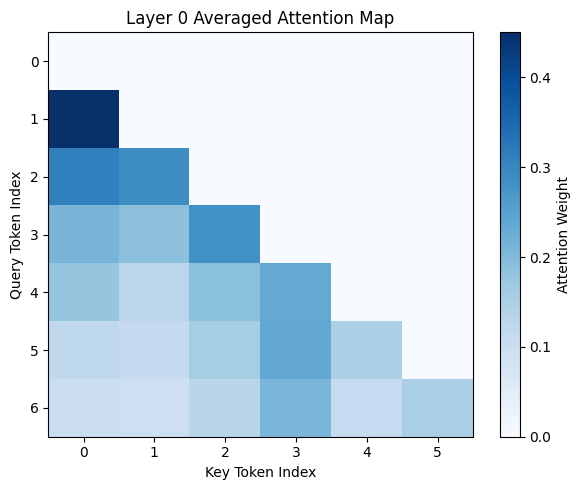

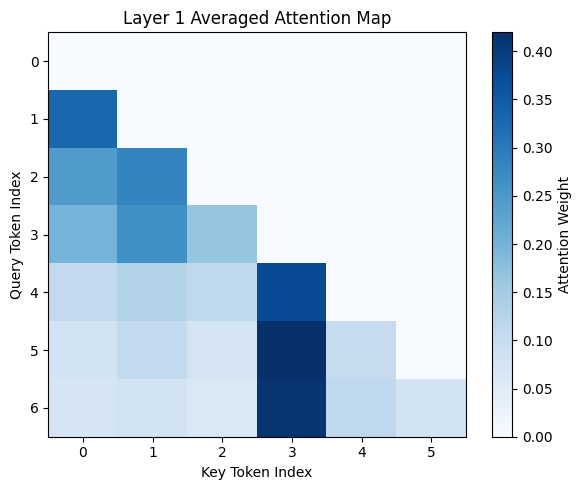

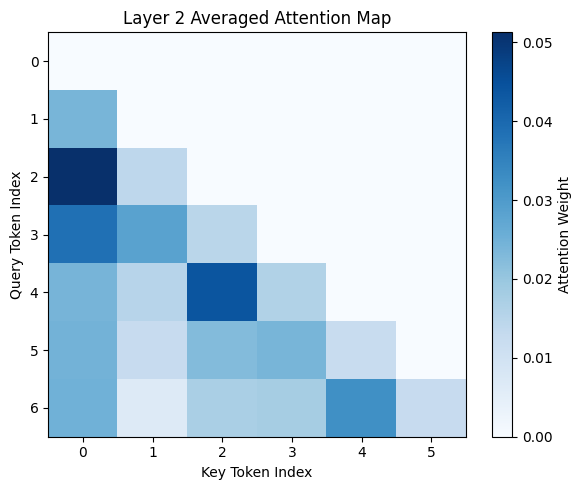

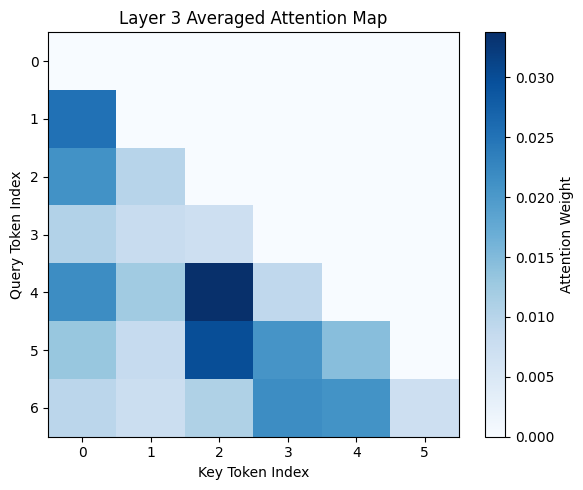

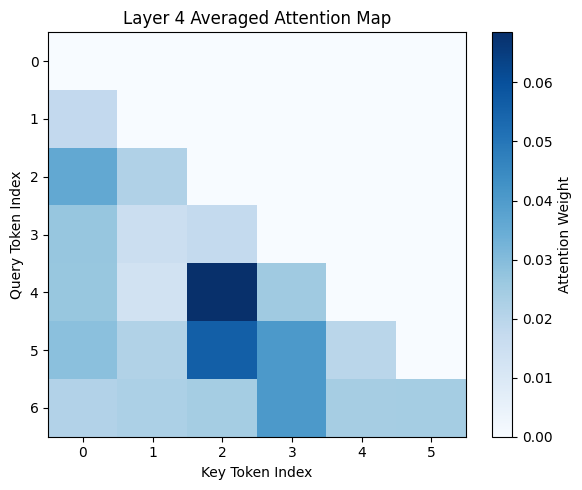

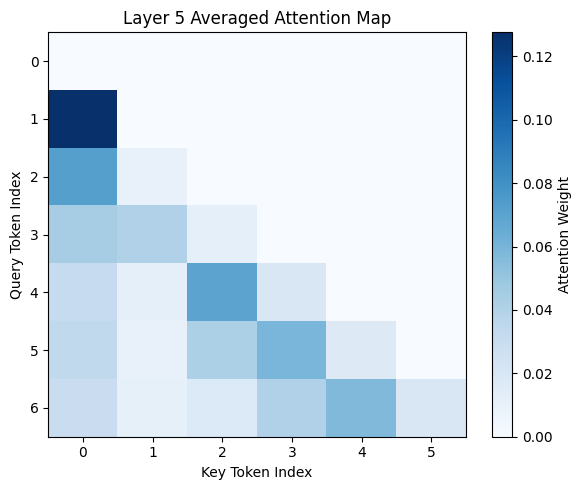

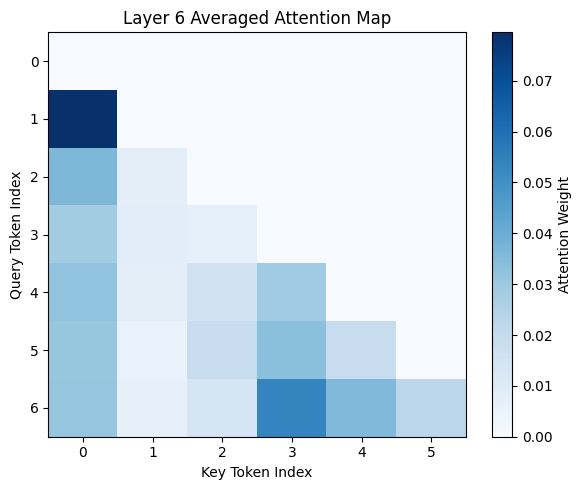

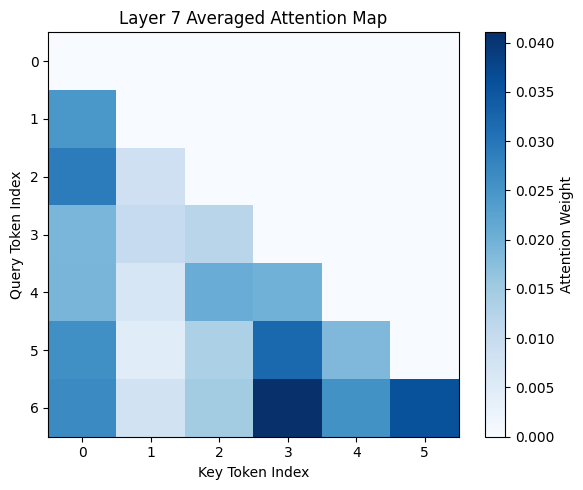

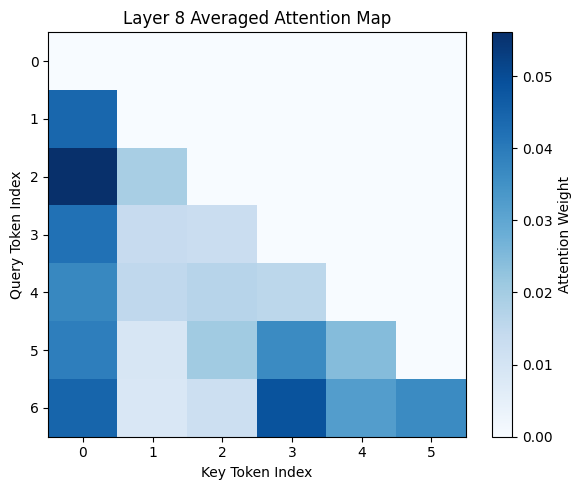

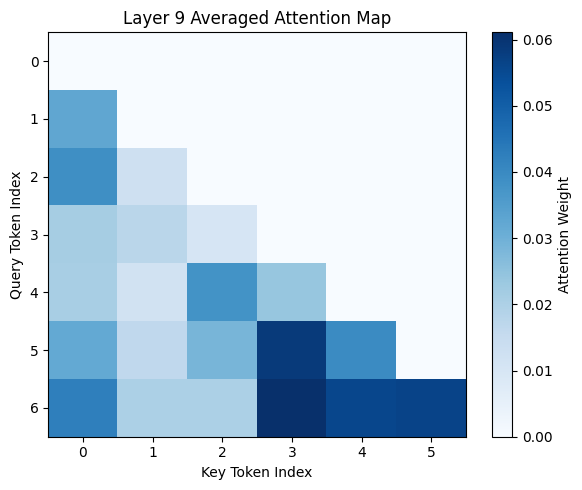

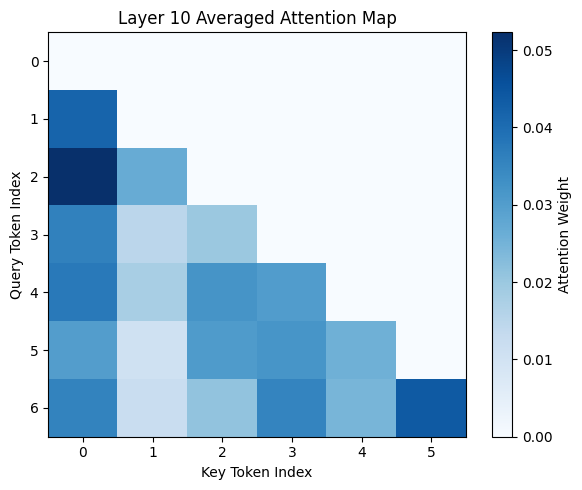

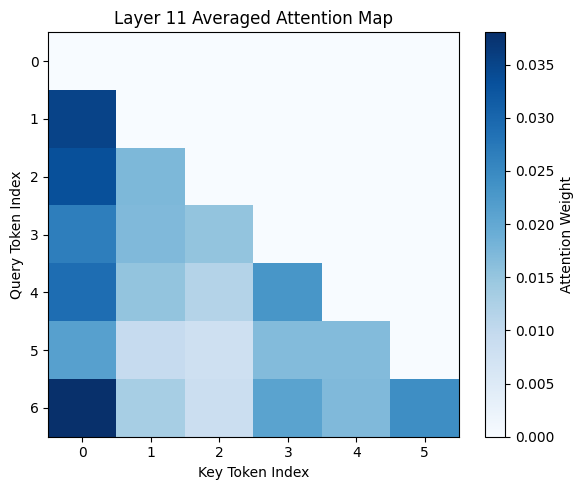

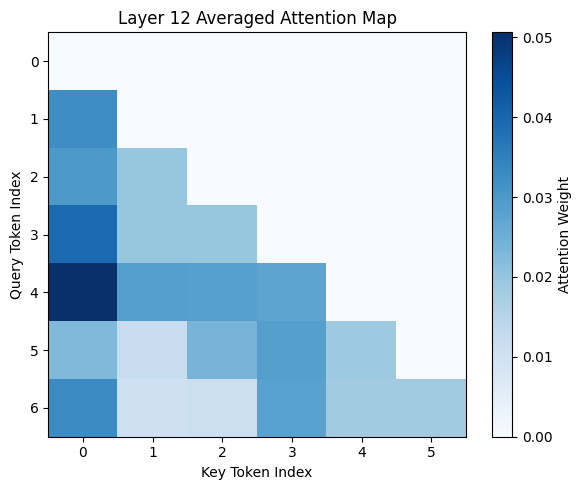

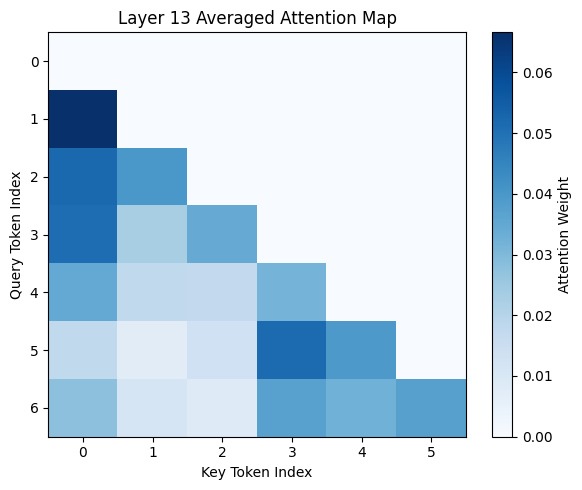

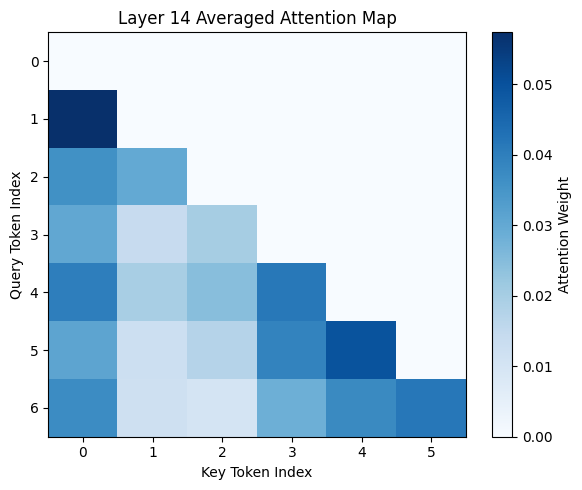

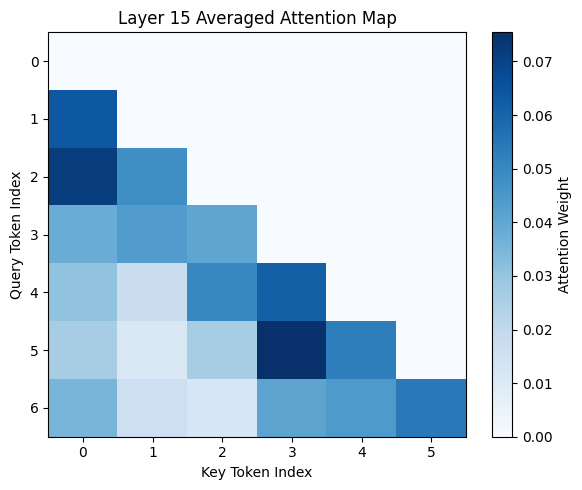

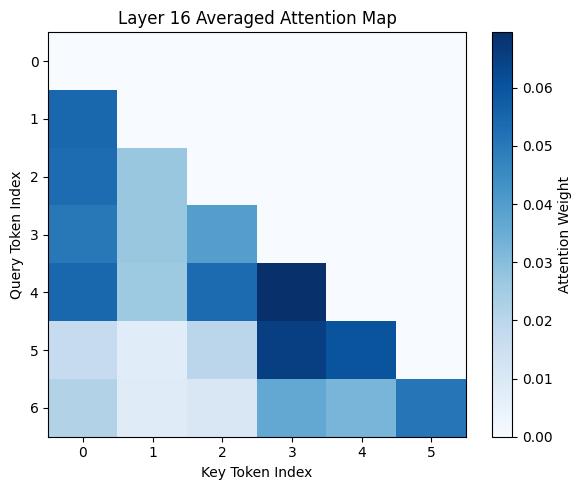

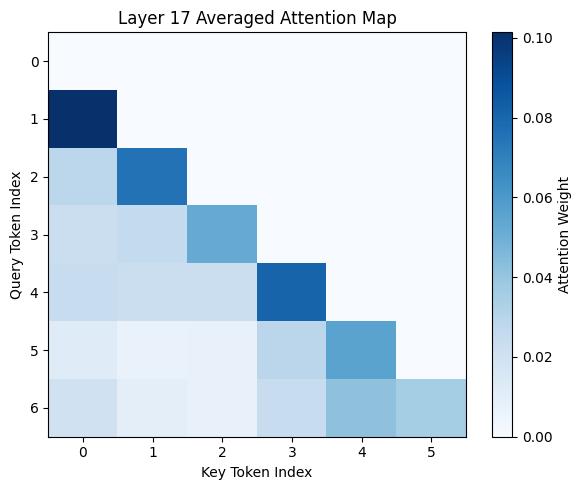

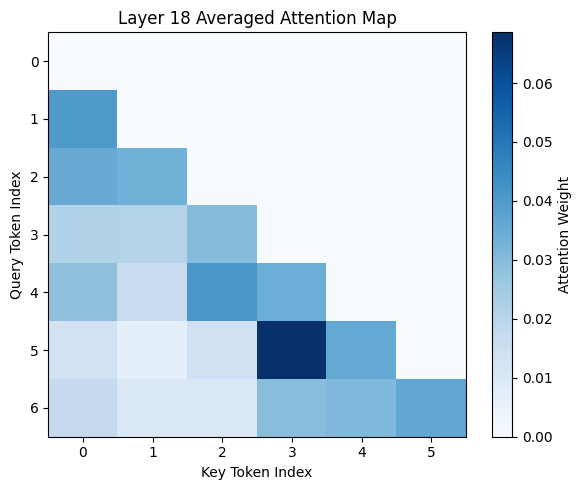

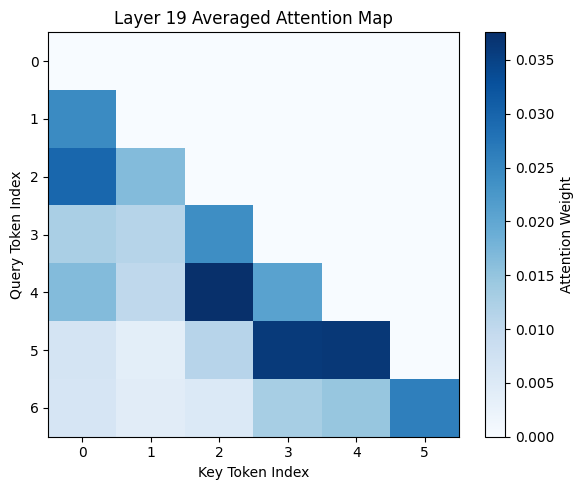

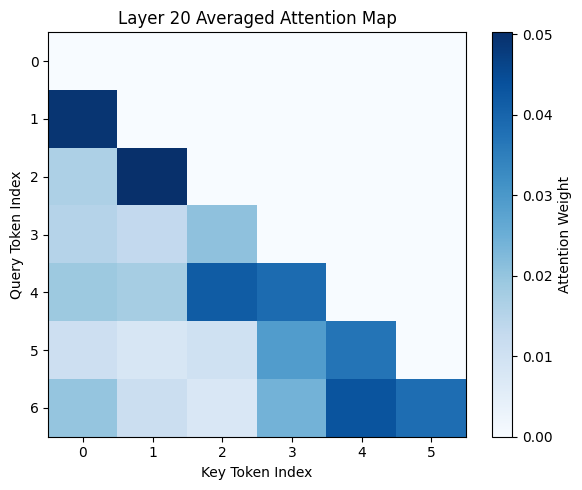

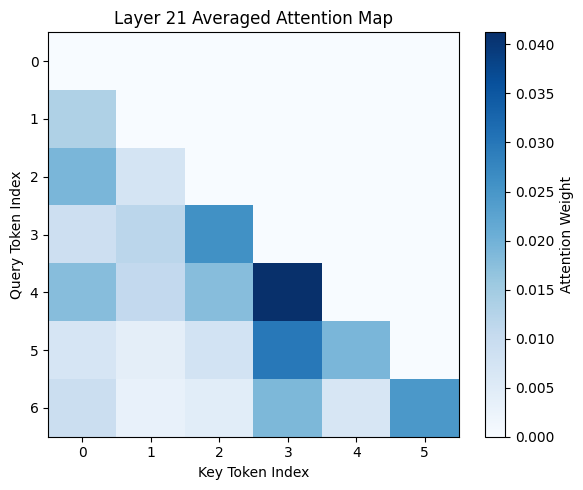

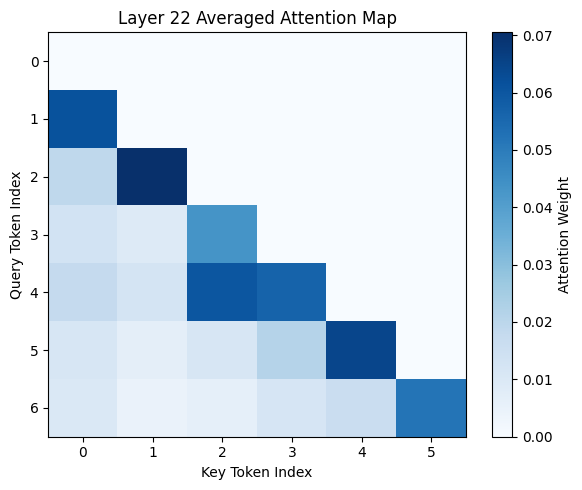

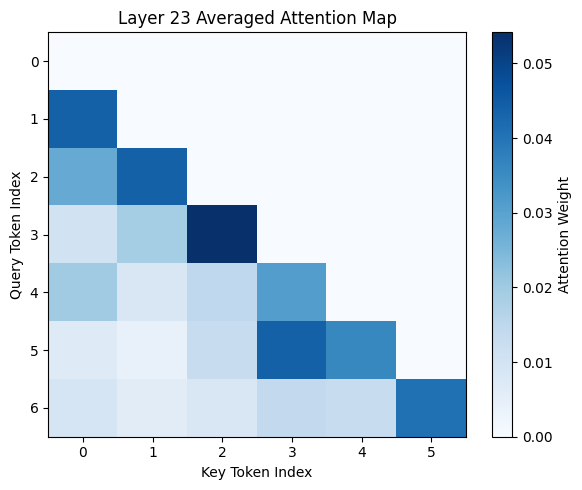

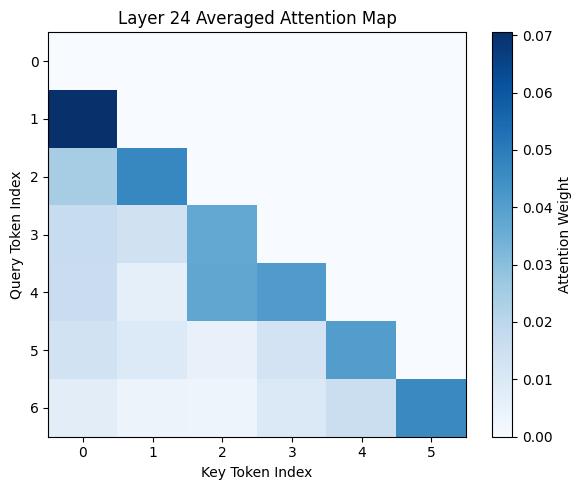

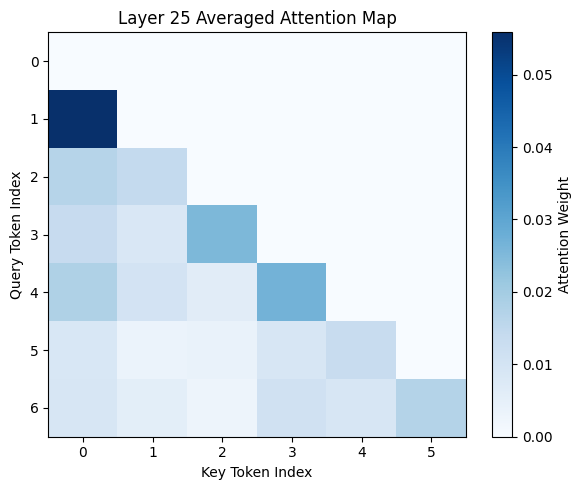

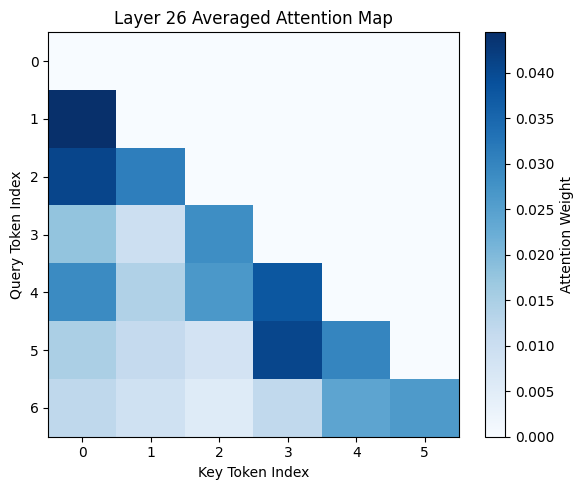

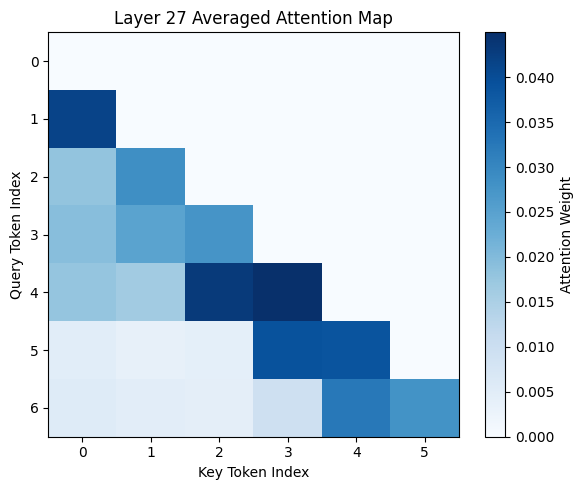

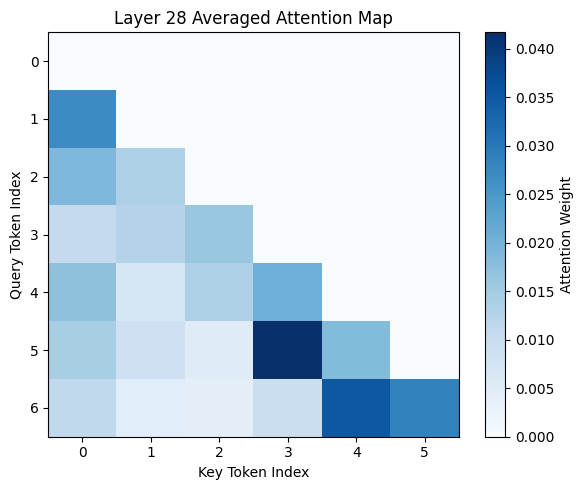

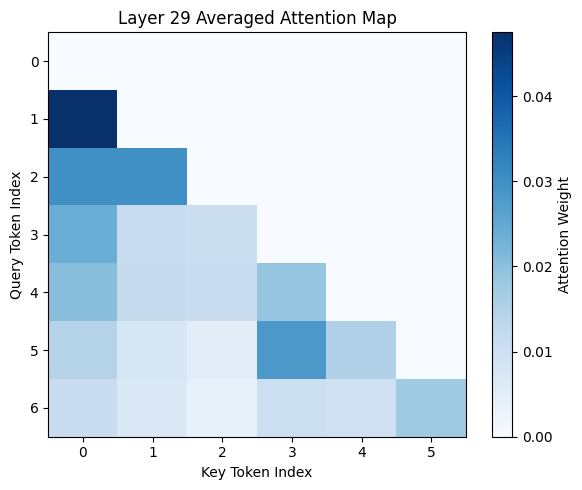

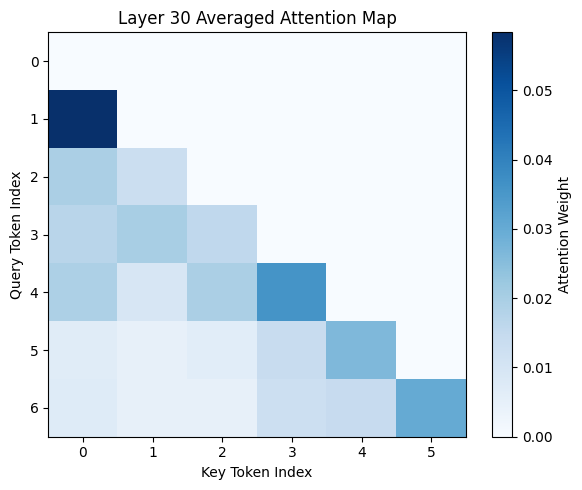

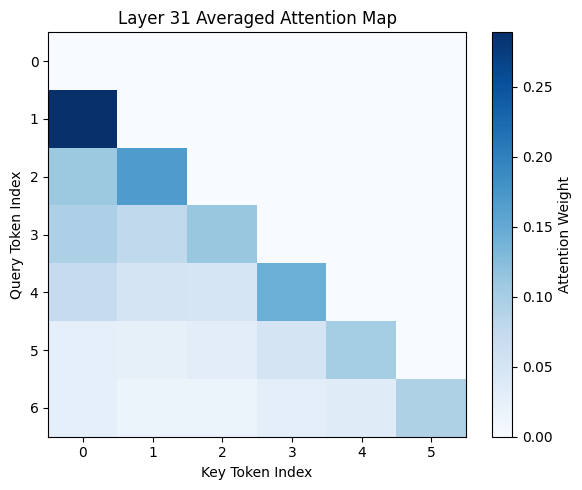

In [33]:
# Plot averaged attention maps per layer (separate figures for each layer)
import matplotlib.pyplot as plt
batch_index = 0
for layer_idx, attn in enumerate(generated_ids.attentions):
    attn_matrix = attn[batch_index]  # [num_heads, seq_len, seq_len]
    avg_attn = attn_matrix[:,:,1:].mean(dim=0).cpu().detach().numpy()  # [seq_len, seq_len]
    plt.figure(figsize=(6, 5))
    plt.imshow(avg_attn, cmap='Blues', aspect='auto')
    plt.title(f'Layer {layer_idx} Averaged Attention Map')
    plt.xlabel('Key Token Index')
    plt.ylabel('Query Token Index')
    plt.colorbar(label='Attention Weight')
    plt.tight_layout()
    plt.show()